### Libraries

In [1]:
#%run ../Getting_data/Getting_Data.ipynb

In [2]:
import datetime as dt
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50, 15]
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder

### Plotting the target

In [3]:
def plot_year_x(year,df,column):
    """
    With this function we will plot the time series of the year that we indicate.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    # We create the dataframe to plot
    plot=df[df['datetime'].dt.year==year][[column,'datetime']]
    # We plot the dataframe
    sns.lineplot(x='datetime',y=column,data=plot)

def plot_all_years(df,column,resampling='D'):
    """
    With this function we will plot all the years, resampled by the period we indicate. The values shown will be the 
    mean of the period
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    # We create the dataframe to plot
    df_aux=df.set_index('datetime')[column].resample(resampling).mean()
    # We plot the dataframe
    sns.lineplot(x=df_aux.index,y=df_aux)  

First, we read our dataframe with the data:

In [4]:
df = pd.read_csv('TFM_dataframe.csv',parse_dates=['datetime','datetime_utc','tz_time'])

Then we can plot our target:

/home/joeldela/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)


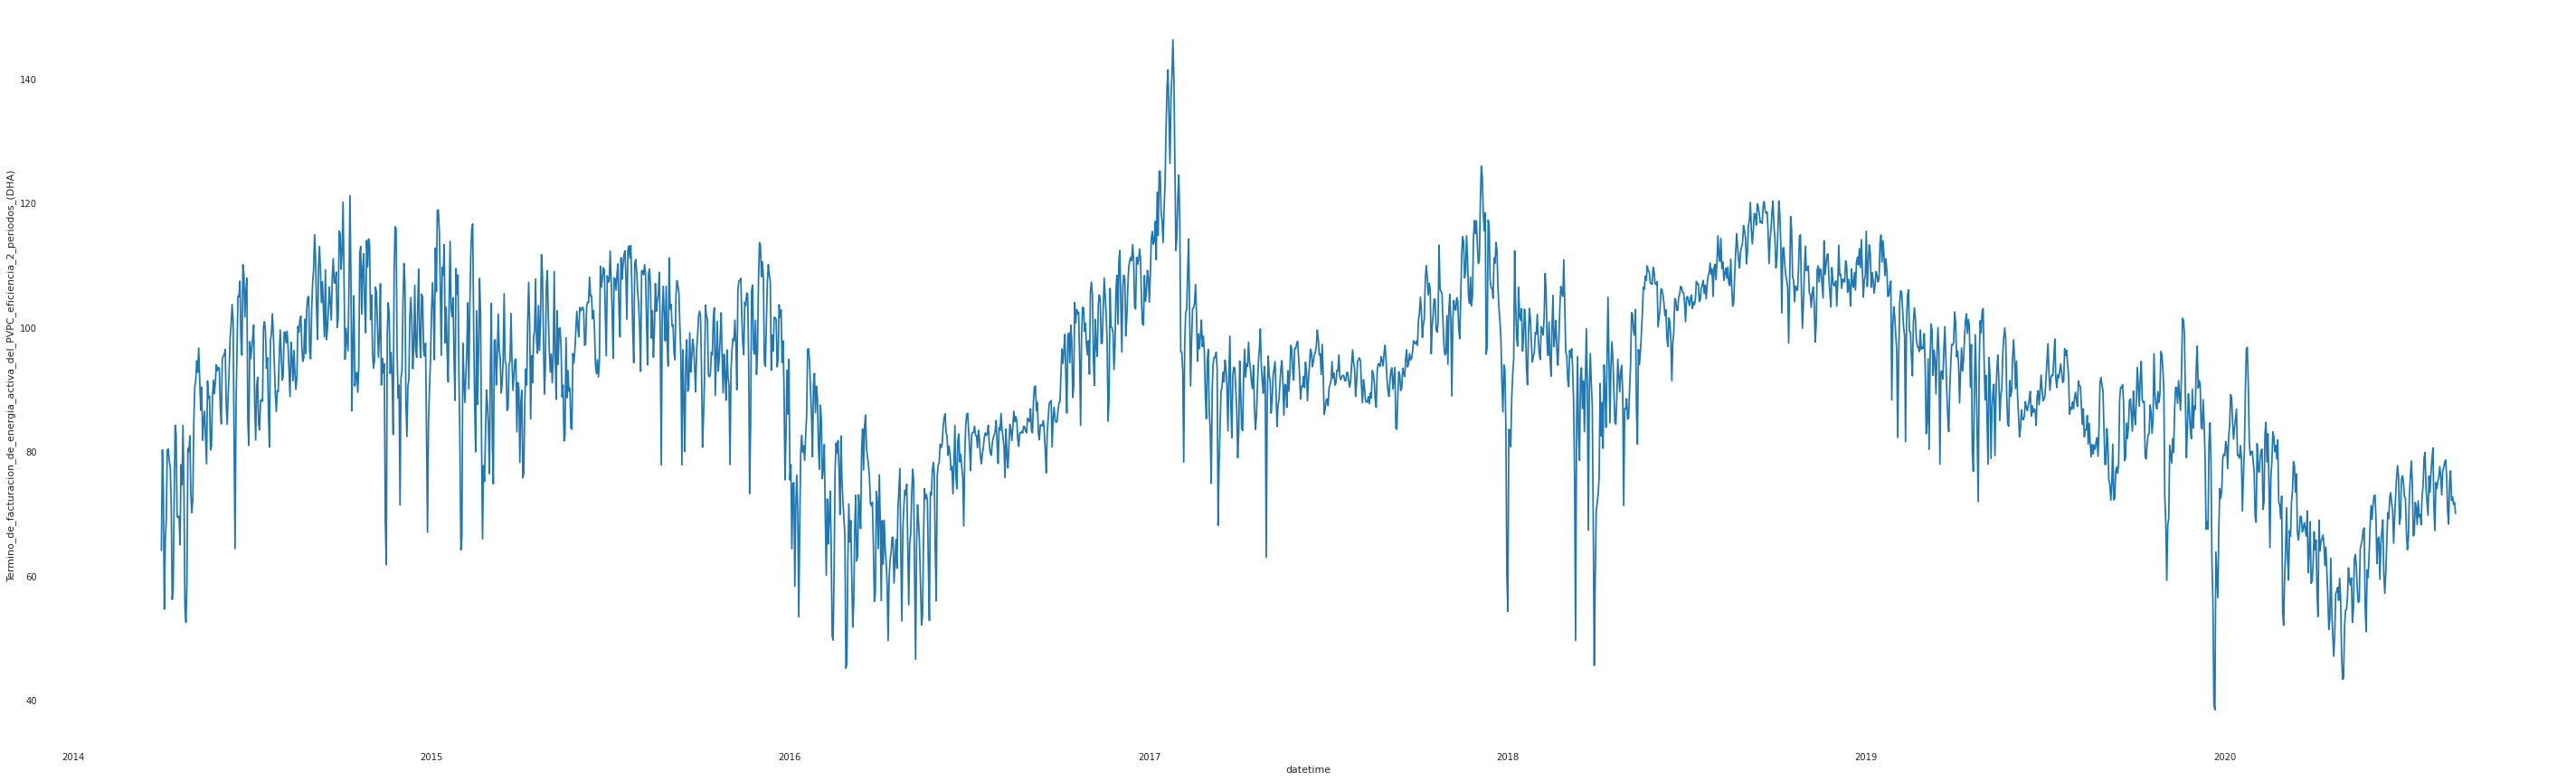

In [5]:
plt.rcParams['figure.figsize'] = [50, 15]
plot_all_years(df,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)')

Let's check the info of our dataframe:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56086 entries, 0 to 56085
Data columns (total 55 columns):
Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)    56086 non-null float64
datetime                                                                         56086 non-null datetime64[ns, UTC]
datetime_utc                                                                     56086 non-null datetime64[ns, UTC]
tz_time                                                                          56086 non-null datetime64[ns, UTC]
geo_id                                                                           56086 non-null int64
geo_name                                                                         56086 non-null object
Demanda_programada_P48_total                                                     56086 non-null float64
Precio_mercado_SPOT_Diario                                                       56086 non-null float64
Precio_mercado_SPOT_Intrad

### Time series index

We are going to consider our data as a time series, so our index must be a datetime:

In [7]:
df = df.set_index('datetime')

### Calculations based on other columns

As we already know, ML models only admit numerical variables, so we need to encode our categorical features in order to get a way of giving them a numerical value. For this objective, we are using a OneHotEncoder with pandas's function **get_dummies**

In [8]:
df['Weekday']=df.index.strftime('%A') # We will get the string weekday
df['Hour']=df.index.hour

In [9]:
df = pd.concat([df,pd.get_dummies(df['Weekday'], prefix='Weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df['Hour'], prefix='Hour')],axis=1)
df = pd.concat([df,pd.get_dummies(df['day'], prefix='Day')],axis=1)
df = pd.concat([df,pd.get_dummies(df['month'], prefix='Month')],axis=1)
df = pd.concat([df,pd.get_dummies(df['year'], prefix='Year')],axis=1)
# now drop the original columns (you don't need them anymore)
df.drop(['day','year','hour','quarter','geo_id','geo_name','datetime_utc','tz_time'],axis=1, inplace=True)

For the hour, month and the weekday we may use the cyclical feature technique. It consists on assuming a cyrcle where you distribute the values for the variable. It is based on the fact that the distance between each value is the same for the next and for the last value, so it can be resumed in a variable from 0-1

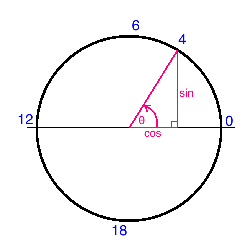
Source: http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

For the hours:

In [10]:
df['sin_hour'] = np.sin(df['Hour']*(2*np.pi)/24)
df['cos_hour'] = np.cos(df['Hour']*(2*np.pi)/24)

For the months:

In [11]:
labelencoder1 = LabelEncoder()
df['month'] = labelencoder1.fit_transform(df['month'])
df['sin_month'] = np.sin(df['month']*(2*np.pi)/12)
df['cos_month'] = np.cos(df['month']*(2*np.pi)/12)

For the weekdays:

In [12]:
labelencoder2 = LabelEncoder()
df['Weekday'] = labelencoder2.fit_transform(df['Weekday'])
df['sin_weekday'] = np.sin(df['Weekday']*(2*np.pi)/7)
df['cos_weekday'] = np.cos(df['Weekday']*(2*np.pi)/7)

### Fill NaN values

Some of the information is in a quarterly period time, so for the current quarter there is no information. In that case, as a simple assumption, we are "forward filling" the NaN values.

In [13]:
df['PIB_Trimestral'] = df['PIB_Trimestral'].ffill()
df['PIB_Trimestral'] = (df['PIB_Trimestral'].str[:-3].astype(float)*1000).astype(int)

In [14]:
df['Var_Trim_PIB_(%)'] = df['Var_Trim_PIB_(%)'].ffill()
df['Var_Trim_PIB_(%)'] = df['Var_Trim_PIB_(%)'].str[:-1].str.replace(',','.').astype(float)

In [15]:
df['Var_anual_PIB_Trim_(%)'] = df['Var_anual_PIB_Trim_(%)'].ffill()
df['Var_anual_PIB_Trim_(%)'] = df['Var_anual_PIB_Trim_(%)'].str[:-1].str.replace(',','.').astype(float)

In [16]:
df['Consumer_price_index'] = df['Consumer_price_index'].ffill()
df['Time_required_to_get_electricity_(days)'] = df['Time_required_to_get_electricity_(days)'].ffill()
df['Inflation,consumer_prices_(annual_%)'] = df['Inflation,consumer_prices_(annual_%)'].ffill()
df['Employment_in_industry_(%_of_total_employment)'] = df['Employment_in_industry_(%_of_total_employment)'].ffill()

The stock market opens at 9:00 and closes at 17:30, but we are considering it as 18:00 so it fits our index. Between those ours, we are interpolating with a linear method. It is not the best method, but it may be approximated.

In [17]:
df['IBEX35']=df['IBEX35'].interpolate(method='linear', limit_area='inside')
df['Red_Electrica']=df['Red_Electrica'].interpolate(method='linear', limit_area='inside')

For the temperature, the same assumpation will be considered:

In [19]:
df['Temperature']=df['Temperature'].interpolate(method='linear', limit_area='inside')

For the 2 first sessions there are only a few values left, so we are interpolating them. For the rest of the sessions, values can be assumed to be NaN.

In [18]:
df['Precio_mercado_SPOT_Intradiario_Sesion_1']=df['Precio_mercado_SPOT_Intradiario_Sesion_1'].interpolate(method='linear', limit_area='inside')
df['Precio_mercado_SPOT_Intradiario_Sesion_2']=df['Precio_mercado_SPOT_Intradiario_Sesion_2'].interpolate(method='linear', limit_area='inside')
df['Precio_mercado_SPOT_Intradiario_Sesion_3']=df['Precio_mercado_SPOT_Intradiario_Sesion_3'].fillna(0)
df['Precio_mercado_SPOT_Intradiario_Sesion_4']=df['Precio_mercado_SPOT_Intradiario_Sesion_4'].fillna(0)
df['Precio_mercado_SPOT_Intradiario_Sesion_5']=df['Precio_mercado_SPOT_Intradiario_Sesion_5'].fillna(0)
df['Precio_mercado_SPOT_Intradiario_Sesion_6']=df['Precio_mercado_SPOT_Intradiario_Sesion_6'].fillna(0)
df['Precio_mercado_SPOT_Intradiario_Sesion_7']=df['Precio_mercado_SPOT_Intradiario_Sesion_7'].fillna(0)

We may consider that if the programmed generation of power is null it may be because it is considered 0:

In [20]:
df[df.columns[pd.Series(df.columns).str.contains('Correccion|Generacion')]]=df[df.columns[pd.Series(df.columns).str.contains('Correccion|Generacion')]].fillna(0)

Let's merge all the columns for the generation and demand of power:

In [21]:
idx = df.columns.str.startswith('Generacion')
df['Generacion'] = df.iloc[:,idx].sum(axis=1)

In [22]:
idx = df.columns.str.startswith('Demanda')
df['Demanda'] = df.iloc[:,idx].sum(axis=1)

### Correlations

We are going to check the correlation matrix:

In [23]:
df.corr().style.background_gradient(cmap='coolwarm')

If we want to know those features that are quite correlated with our target, filtering with 0.3 and -0.3:

In [24]:
y_corr = df.corr()['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
y_corr[(y_corr>0.3)|(y_corr<-0.3)]

Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)    1.000000
Demanda_programada_P48_total                                                     0.571324
Precio_mercado_SPOT_Diario                                                       0.545582
Precio_mercado_SPOT_Intradiario_Sesion_1                                         0.536043
Precio_mercado_SPOT_Intradiario_Sesion_2                                         0.529297
Precio_mercado_SPOT_Intradiario_Sesion_3                                         0.556013
Precio_mercado_SPOT_Intradiario_Sesion_4                                         0.635150
Precio_mercado_SPOT_Intradiario_Sesion_5                                         0.763426
Precio_mercado_SPOT_Intradiario_Sesion_6                                         0.682560
Generacion_programada_P48_Consumo_bombeo                                         0.410309
Generacion_programada_P48_Enlace_Baleares                                       -0.446087
Generacion

We may see it better in a heat map:

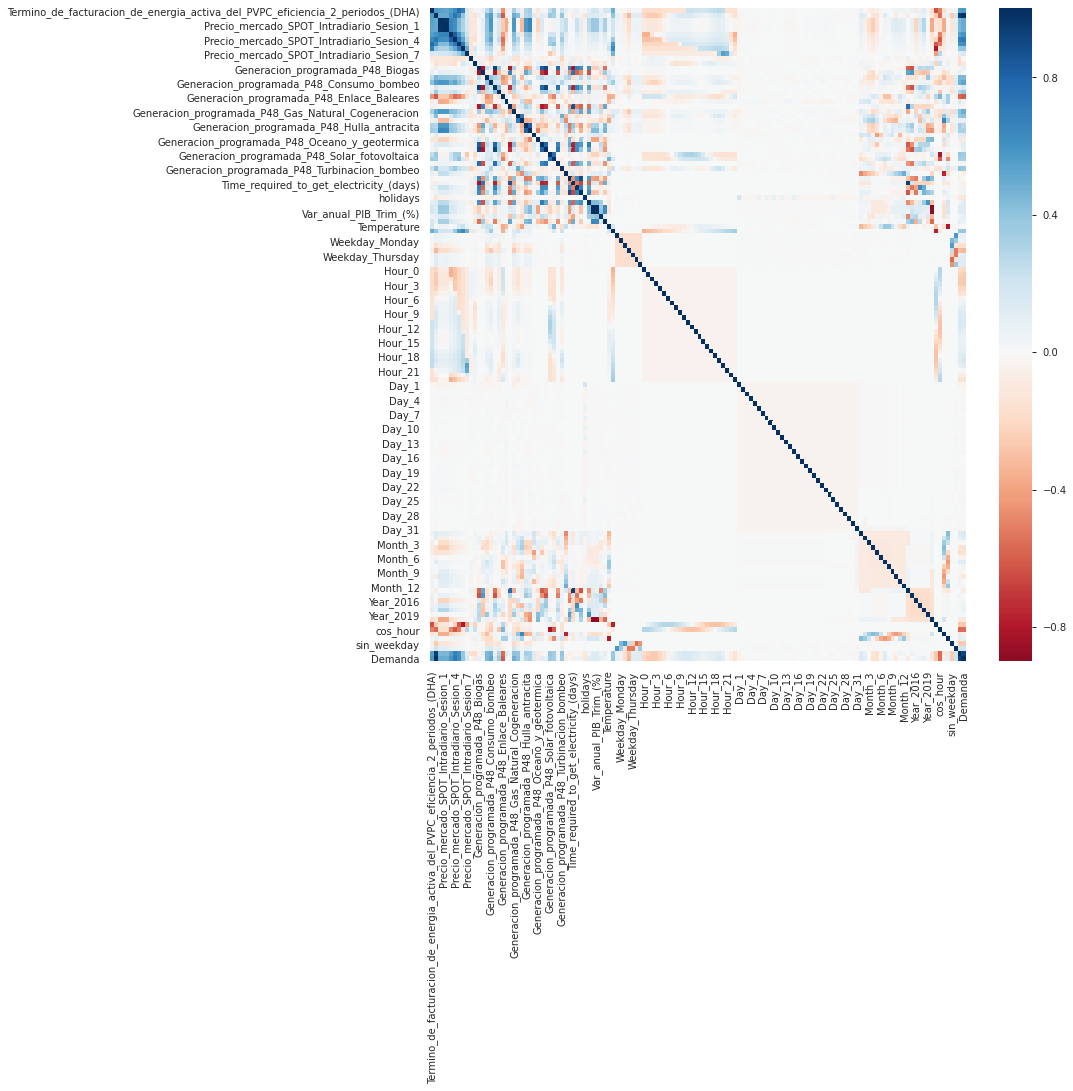

In [25]:
plt.rcParams['figure.figsize'] = [12, 12]
sns.heatmap(df.drop('Weekday',axis=1).corr(),cmap='RdBu',center=0)

There is a special type of heatmap called "clustermap". It mixed a heatmap and a clusterization of the features. It creates groups of similar features and group them by levels.

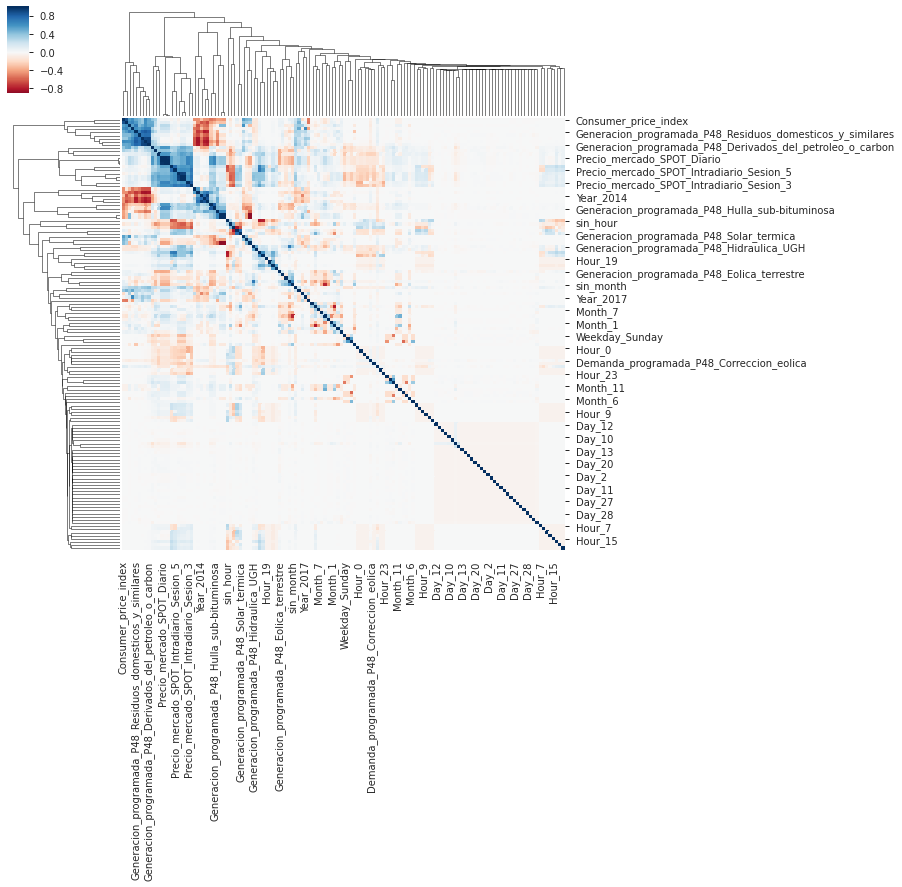

In [26]:
# We drop Weekday because it is a string column
sns.clustermap(df.drop('Weekday',axis=1).corr(),cmap='RdBu',center=0) 

### Statistics

Finally we are creating a report with all the statistic information of the dataset.

In [27]:
# We need to change the binary columns to categorical for the report:
df_profile = df.copy()
for col in df_profile.columns:
    if (len(df_profile[col].unique())==2) & (1 in df_profile[col].unique()):
        df_profile[col] = df_profile[col].astype('category')

In [28]:
# Let's print the full report
prof2 = ProfileReport(df_profile, minimal = False)
prof2.to_file(output_file='output_full.html')

In [29]:
# Let's print the small report
prof1 = ProfileReport(df_profile, minimal = True)
prof1.to_file(output_file='output.html')

### Exporting the dataframe

In [30]:
df.to_csv('../Models/final_dataframe.csv')